## Importing Libraries

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import warnings
warnings.filterwarnings('ignore')

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [3]:
paths = []
labels = []

In [4]:
for dirname, _, filenames in os.walk('./TESS Toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        if label == 'ps':
            label='surprise'
        labels.append(label.lower())

print("TESS Dataset is Loaded")


TESS Dataset is Loaded


In [5]:
paths[:5]

['./TESS Toronto emotional speech set data/OAF_disgust/OAF_ripe_disgust.wav',
 './TESS Toronto emotional speech set data/OAF_disgust/OAF_dog_disgust.wav',
 './TESS Toronto emotional speech set data/OAF_disgust/OAF_chat_disgust.wav',
 './TESS Toronto emotional speech set data/OAF_disgust/OAF_fit_disgust.wav',
 './TESS Toronto emotional speech set data/OAF_disgust/OAF_live_disgust.wav']

In [6]:
labels[:5]

['disgust', 'disgust', 'disgust', 'disgust', 'disgust']

In [7]:
# create a dataframe
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,./TESS Toronto emotional speech set data/OAF_d...,disgust
1,./TESS Toronto emotional speech set data/OAF_d...,disgust
2,./TESS Toronto emotional speech set data/OAF_d...,disgust
3,./TESS Toronto emotional speech set data/OAF_d...,disgust
4,./TESS Toronto emotional speech set data/OAF_d...,disgust


In [8]:
df.shape

(2800, 2)

In [9]:
df['label'].value_counts()

label
disgust     400
angry       400
sad         400
surprise    400
happy       400
neutral     400
fear        400
Name: count, dtype: int64

In [10]:
df.to_csv("data_path.csv",index=False)

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

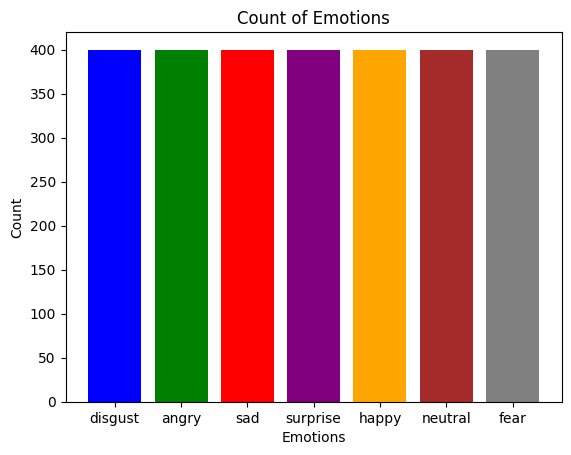

In [11]:
# Define the colors for each emotion label
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'gray', 'black']

# Count the number of samples for each emotion label
label_counts = df['label'].value_counts()

# Create a bar chart with different colors for each label
plt.bar(label_counts.index, label_counts.values, color=colors)

# Set the title and axis labels
plt.title('Count of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Count')

# Display the plot
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [12]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
     x = librosa.stft(data)
     xdb = librosa.amplitude_to_db(abs(x))
     plt.figure(figsize=(11,4))
     plt.title(emotion, size=20)
     librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
     plt.colorbar()

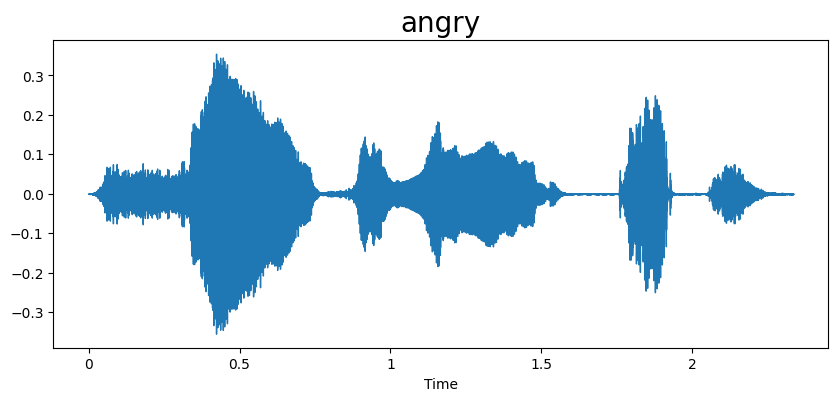

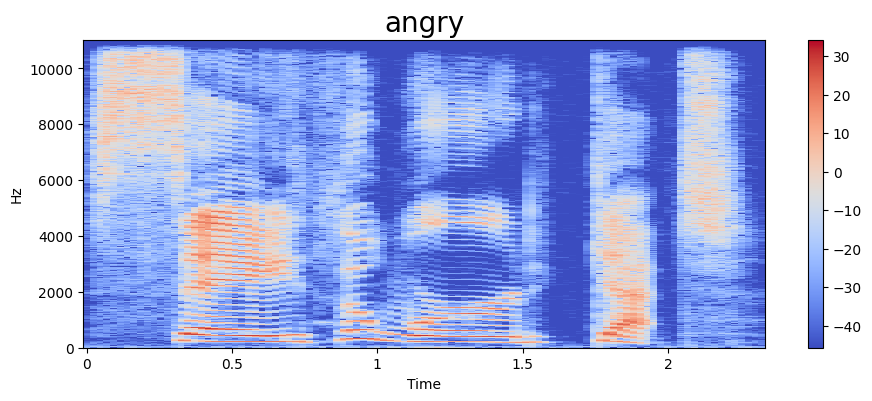

In [13]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

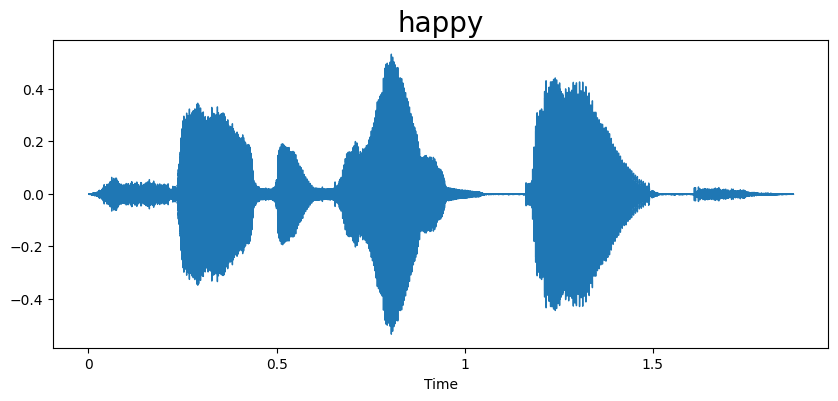

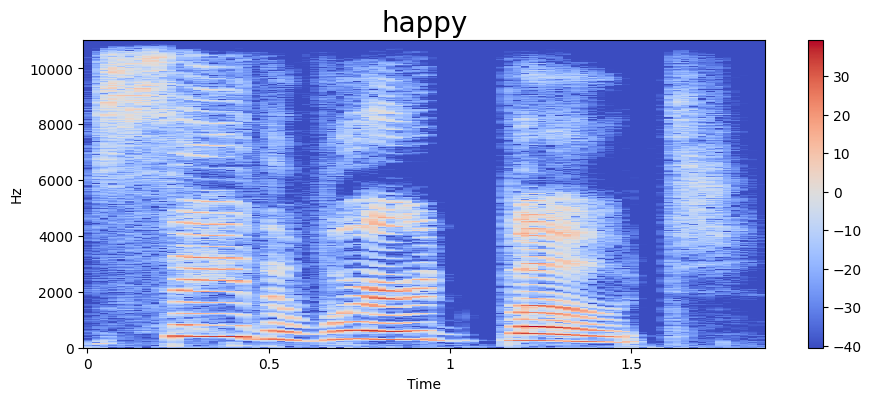

In [14]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

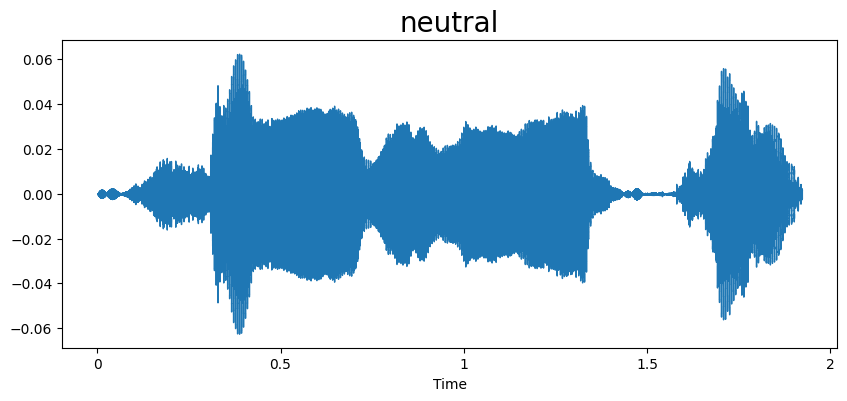

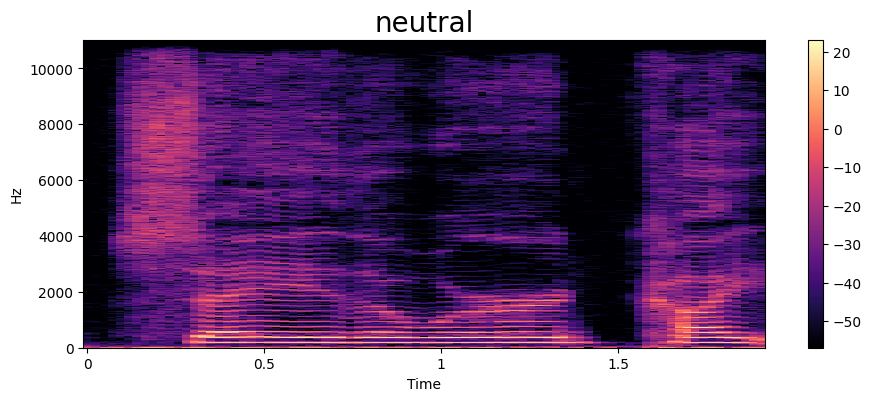

In [15]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

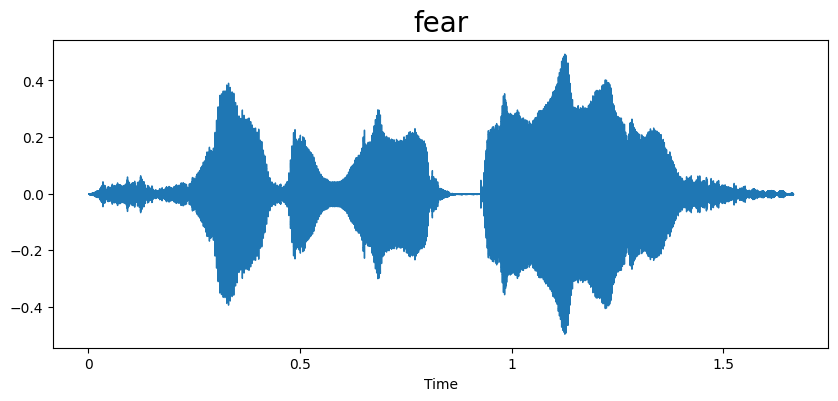

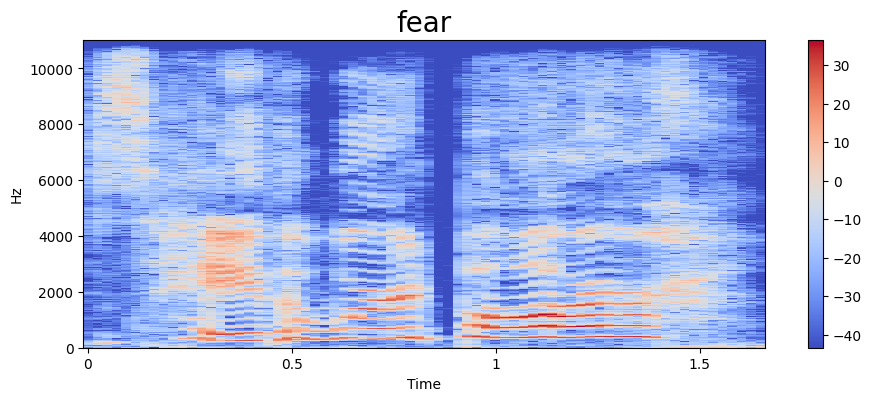

In [16]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [17]:
emotion = 'surprise'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

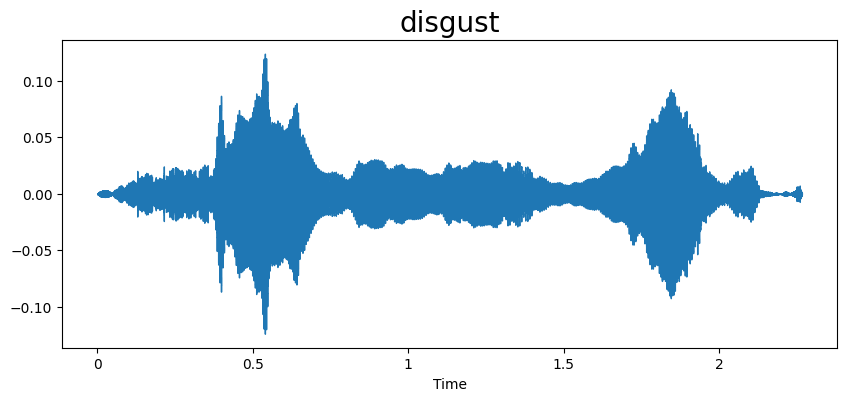

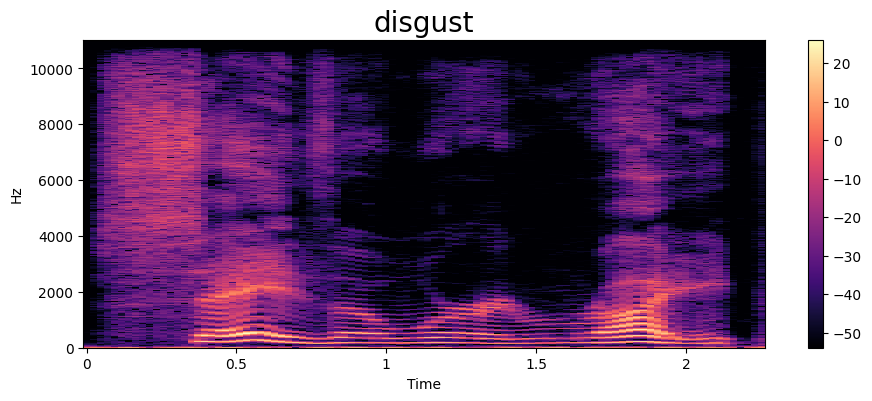

In [18]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

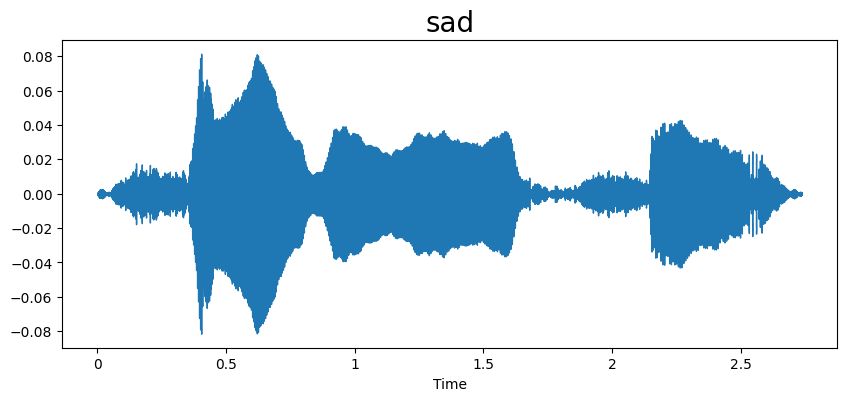

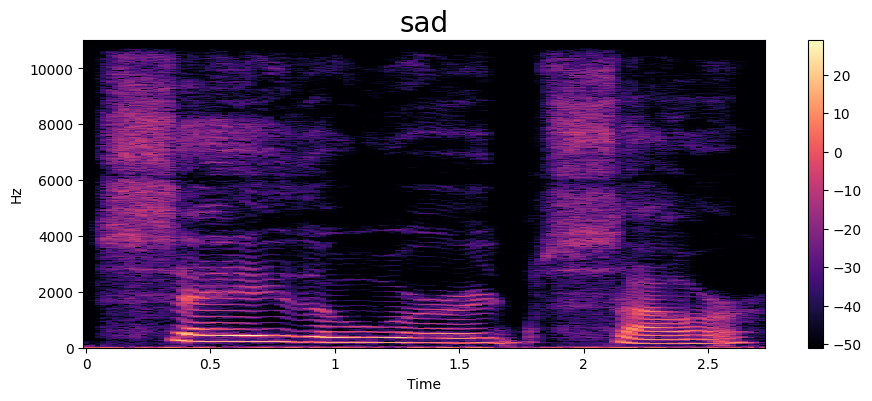

In [19]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
In this project we use MFCCs (Mel Frequency Cepstral Coefficients) form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [20]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [21]:
extract_mfcc(df['speech'][0])

array([-4.8677170e+02,  1.1570472e+02,  1.8785555e+01, -1.0474499e+01,
        1.4632906e+01, -2.1465074e-01, -2.5612535e+00, -1.1263777e+00,
       -2.2530544e+01, -4.5003276e+00, -1.5531698e+01,  1.9253836e+00,
       -1.4981126e+00, -3.3637013e+00, -3.3196096e+00,  4.7380438e+00,
       -4.1450887e+00,  1.4781676e-01, -5.4977745e-01,  1.1256258e+00,
       -1.2838145e+00, -3.3934369e+00, -5.1048918e+00,  5.9826785e-01,
       -5.3996148e+00,  4.1478415e+00, -1.0816739e+00,  2.4705827e+00,
       -2.7299757e+00,  1.0955178e+00, -5.4149585e+00,  9.5388448e-01,
       -2.5175309e+00,  1.9429426e+00,  3.7613263e+00,  3.6275814e+00,
        8.4863329e+00,  1.1782988e+01,  1.6902363e+01,  2.2236372e+01],
      dtype=float32)

In [23]:
X_mfcc = []
for x in tqdm(df['speech'], ncols=180):
    X_mfcc.append(extract_mfcc(x))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2800/2800 [02:39<00:00, 17.57it/s]


In [24]:
X_mfcc

[array([-4.8677170e+02,  1.1570472e+02,  1.8785555e+01, -1.0474499e+01,
         1.4632906e+01, -2.1465074e-01, -2.5612535e+00, -1.1263777e+00,
        -2.2530544e+01, -4.5003276e+00, -1.5531698e+01,  1.9253836e+00,
        -1.4981126e+00, -3.3637013e+00, -3.3196096e+00,  4.7380438e+00,
        -4.1450887e+00,  1.4781676e-01, -5.4977745e-01,  1.1256258e+00,
        -1.2838145e+00, -3.3934369e+00, -5.1048918e+00,  5.9826785e-01,
        -5.3996148e+00,  4.1478415e+00, -1.0816739e+00,  2.4705827e+00,
        -2.7299757e+00,  1.0955178e+00, -5.4149585e+00,  9.5388448e-01,
        -2.5175309e+00,  1.9429426e+00,  3.7613263e+00,  3.6275814e+00,
         8.4863329e+00,  1.1782988e+01,  1.6902363e+01,  2.2236372e+01],
       dtype=float32),
 array([-4.9469727e+02,  1.1262854e+02,  2.3517117e+01, -5.8728142e+00,
         6.0156507e+00,  1.0053787e+00, -3.6962810e+00,  5.2565980e+00,
        -1.6794617e+01, -3.3578000e+00, -9.4928665e+00,  9.6773368e-01,
        -2.1756296e+00, -2.8693230e+00, 

In [25]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape
X

array([[-4.8677170e+02,  1.1570472e+02,  1.8785555e+01, ...,
         1.1782988e+01,  1.6902363e+01,  2.2236372e+01],
       [-4.9469727e+02,  1.1262854e+02,  2.3517117e+01, ...,
         1.1701423e+01,  7.1346178e+00,  5.7037520e+00],
       [-4.5559076e+02,  1.0150316e+02,  5.8394985e+00, ...,
         1.3613542e+01,  1.4771193e+01,  1.1796869e+01],
       ...,
       [-3.7582394e+02,  3.8249294e+01, -3.9017040e-01, ...,
         2.9157417e+00,  1.8822553e+00,  4.7569361e+00],
       [-3.8581958e+02,  1.0604636e+02, -9.2535343e+00, ...,
         5.0235896e+00,  6.2578926e+00,  7.4351807e+00],
       [-3.2268225e+02,  3.8802917e+01, -1.5675197e+01, ...,
         3.0946970e+00,  2.3693454e+00,  4.9797812e+00]], dtype=float32)

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [26]:
# input split
X = np.expand_dims(X, -1)
X.shape

(2800, 40, 1)

In [27]:
encoder = OneHotEncoder()
y = encoder.fit_transform(df[['label']])

In [28]:
y = y.toarray()

In [29]:
y.shape

(2800, 7)

In [30]:
x_train, x_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=.35)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1820, 40, 1), (1820, 7), (980, 40, 1), (980, 7))

## Modelling

In [31]:
# Create LSTM Model

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

2023-05-22 09:23:12.210220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-22 09:23:12.211879: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 4

2023-05-22 09:23:12.788863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 09:23:12.792608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 09:23:12.795397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Non-trainable params: 0
_________________________________________________________________


In [32]:
# Train the Model

history = model.fit(x_train, y_train, batch_size=1024, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50


2023-05-22 09:23:13.709693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 09:23:13.714595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 09:23:13.717918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - ETA: 0s - loss: 1.8873 - accuracy: 0.2055

2023-05-22 09:23:20.562614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 09:23:20.567463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 09:23:20.570804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 8s 2s/step - loss: 1.8873 - accuracy: 0.2055 - val_loss: 1.7667 - val_accuracy: 0.3867
Epoch 2/50
2/2 [==============================] - 2s 1s/step - loss: 1.7450 - accuracy: 0.3731 - val_loss: 1.6013 - val_accuracy: 0.4673
Epoch 3/50
2/2 [==============================] - 2s 1s/step - loss: 1.5908 - accuracy: 0.4396 - val_loss: 1.4184 - val_accuracy: 0.4980
Epoch 4/50
2/2 [==============================] - 2s 1s/step - loss: 1.4413 - accuracy: 0.4599 - val_loss: 1.2258 - val_accuracy: 0.5459
Epoch 5/50
2/2 [==============================] - 2s 1s/step - loss: 1.2423 - accuracy: 0.5264 - val_loss: 0.9940 - val_accuracy: 0.6408
Epoch 6/50
2/2 [==============================] - 2s 1s/step - loss: 1.0819 - accuracy: 0.5681 - val_loss: 0.8202 - val_accuracy: 0.6959
Epoch 7/50
2/2 [==============================] - 2s 1s/step - loss: 0.9789 - accuracy: 0.5874 - val_loss: 0.7108 - val_accuracy: 0.7520
Epoch 8/50
2/2 [==============================] - 2s

31/31 [==============================] - 1s 30ms/step - loss: 0.0757 - accuracy: 0.9755
Accuracy of our model on test data :  97.55101799964905 %


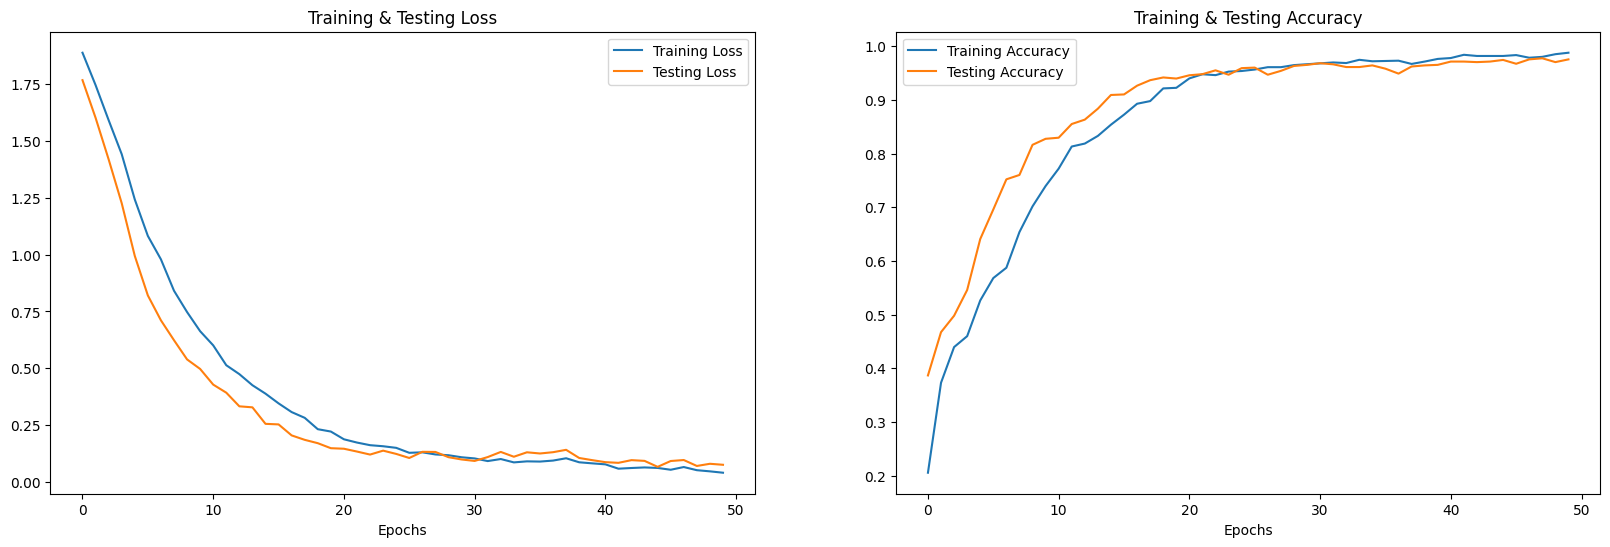

In [33]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [34]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

2023-05-22 09:25:07.439001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 09:25:07.443973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 09:25:07.448949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 3s 58ms/step


In [35]:
x_test.shape

(980, 40, 1)

In [36]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
df.to_csv('predictions.csv')
print("predictions as saved to ./predictions.csv")

predictions as saved to ./predictions.csv


## Experimental Results and Analysis

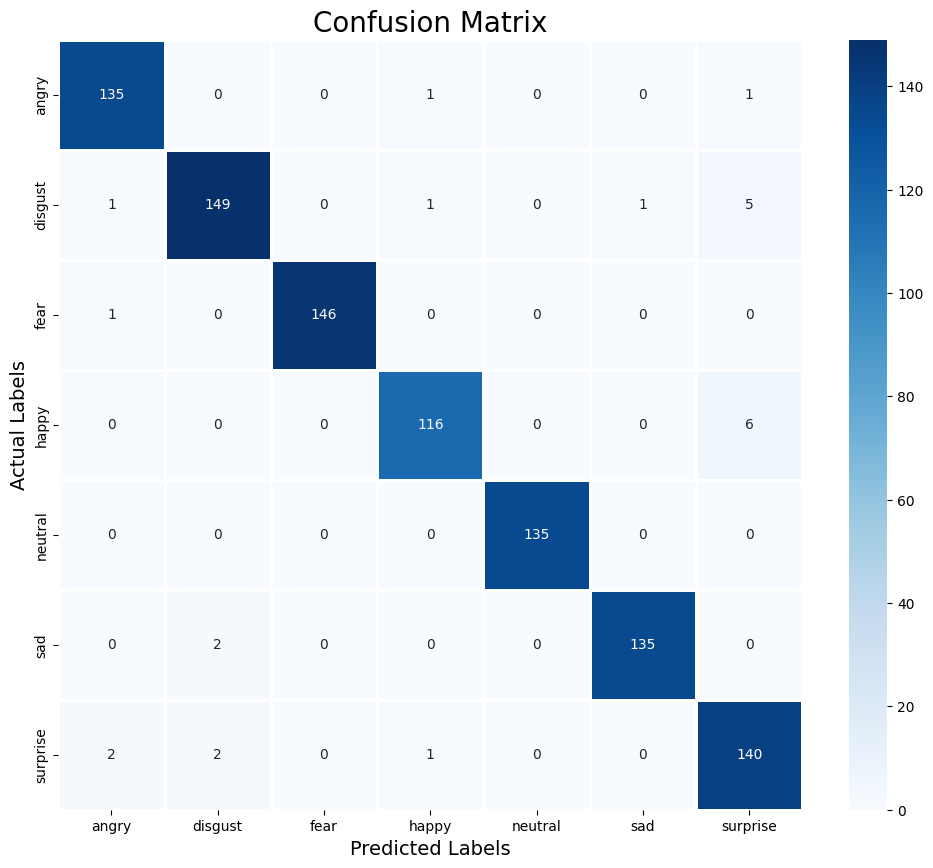

In [37]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.97      0.99      0.98       137
     disgust       0.97      0.95      0.96       157
        fear       1.00      0.99      1.00       147
       happy       0.97      0.95      0.96       122
     neutral       1.00      1.00      1.00       135
         sad       0.99      0.99      0.99       137
    surprise       0.92      0.97      0.94       145

    accuracy                           0.98       980
   macro avg       0.98      0.98      0.98       980
weighted avg       0.98      0.98      0.98       980



## Save the Model

In [39]:
from tensorflow import keras

model.save('mymodel.h5')

my_model = keras.models.load_model('./mymodel.h5')

2023-05-22 09:25:12.687035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 09:25:12.691760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 09:25:12.694974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

## Live Audio Emotion Prediction

In [40]:
#RECORDED USING MICROPHONE:
import pyaudio
import wave

CHUNK = 1024
FORMAT = pyaudio.paInt16 #paInt8
CHANNELS = 2
RATE = 44100 #sample rate
RECORD_SECONDS = 3
WAVE_OUTPUT_FILENAME = "recorded-audio.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")
frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.front
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround21
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround40
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround41
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround50
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround51
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.surround71
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2666:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.iec958
ALSA lib pcm.c:2666:(snd

* recording
* done recording


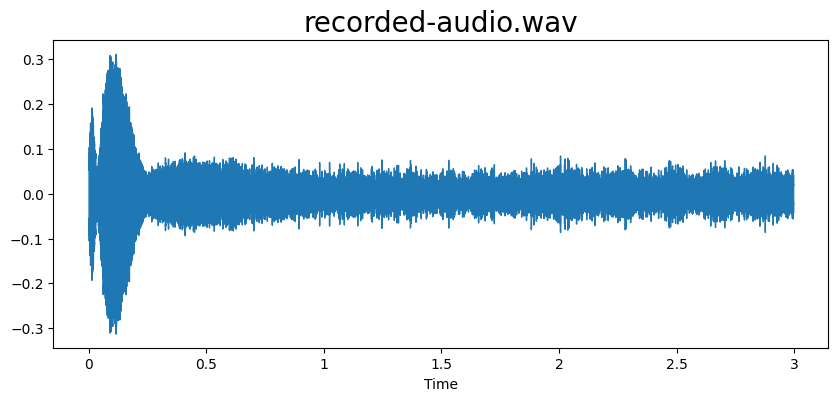

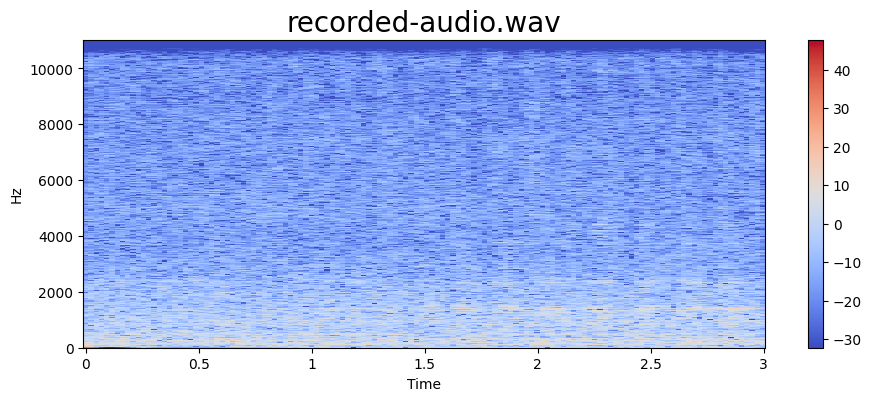

In [42]:
data, sampling_rate = librosa.load('./recorded-audio.wav')
waveplot(data, sampling_rate, 'recorded-audio.wav')
spectogram(data, sampling_rate, 'recorded-audio.wav')
Audio('./recorded-audio.wav')

In [43]:
ans = []
new_feature = extract_mfcc("./recorded-audio.wav")
ans.append(new_feature)
ans = np.array(ans)

In [44]:
audio_pred = my_model.predict(ans)
audio_pred = encoder.inverse_transform(audio_pred)
audio_pred

2023-05-22 09:25:19.981594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-22 09:25:19.987009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-22 09:25:19.991200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 1s 1s/step


array([['disgust']], dtype=object)